# Reference

* Research Paper

  <a href="http://proceedings.mlr.press/v28/agrawal13.html">Agrawal, Shipra, and Navin Goyal. "Thompson sampling for contextual bandits with linear payoffs." International Conference on Machine Learning. PMLR, 2013.</a>

* Regret Bound

  $O(\frac{d^2}{\epsilon}\sqrt{T^{1+\epsilon}}(ln(Td)ln\frac{1}{\delta}))$

* Constraints

  1. Arms could be defined infinite number unlike LinUCB
  2. $||b_i(t)||\leq{1},\ ||\mu||\leq{1},\ \Delta_i(t)\leq{1}$
    
    if it is not adapted at problem setting, regret bound will have scale element.

  3. $\epsilon(0<\epsilon<1)$ is the only one parameter which could be chosen as hyperparameter of model.  



In [10]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [11]:
class Env:
  def __init__(self, k, d, norm=None, random_state=None):
    self.k = k
    self.d = d
    self.norm = norm

    self.seed_initialization(random_state)
    self.true_theta = self.init_theta()

  def init_theta(self):
    if self.norm is not None:
      return normalize(np.random.random((self.d,1)), norm=self.norm, axis=0)
    else:
      return np.random.random((self.d,1))

  def get_observations(self):
    if self.norm is not None:
      return normalize(np.hstack([np.random.random((self.d,1)) for i in range(self.k)]), norm=self.norm, axis=0)
    else:
      return np.hstack([np.random.random((self.d,1)) for i in range(self.k)])

  def seed_initialization(self, random_state):
    np.random.seed(random_state)

In [12]:
class ThompsonSampling:
  def __init__(self, k, d, t, epsilon, norm=None, seed=None, verbose=False):
    self.k = k 
    self.d = d
    self.t = t
    self.epsilon = epsilon
    self.verbose = verbose

    self.env = Env(k,d, norm=norm, random_state=seed)
    self.true_theta = self.env.true_theta
    self.v = self.set_deviation()
  
  def init_matrix(self):
    identity_matrix = np.eye(self.d)
    zero_vector = np.zeros(self.d)

    return identity_matrix, zero_vector, zero_vector

  def set_deviation(self):
    R = 1 # for simplity take 1-mean sub gaussian
    delta = np.random.random(1) # 0 < delta < 1
    return R * np.sqrt(24 / self.epsilon * self.d * np.log(1/delta)) 

  def get_reward(self, obs, theta):
    selected_arm = obs.T.dot(theta).argmax()
    reward = obs[:,selected_arm].dot(self.true_theta)
    
    return selected_arm, reward

  def update_estimates(self, estimates, obs, play_result):
    B, est_theta, f = estimates
    est_arm, est_reward = play_result
    
    B += obs[:,est_arm].reshape(-1,1).dot(obs[:,est_arm].reshape(-1,1).T)
    f += obs[:,est_arm] * est_reward
    est_theta = np.linalg.inv(B).dot(f.reshape(-1,1)).reshape(-1)

    return B, est_theta, f

  def predict(self):
    regrets = []

    B, est_theta, f = self.init_matrix()

    for t in tqdm(range(self.t)):
      tilda_theta = np.random.multivariate_normal(est_theta, self.v**2 * np.linalg.inv(B))

      observation = self.env.get_observations()

      est_arm, est_reward = self.get_reward(observation, tilda_theta)
      true_arm, true_reward = self.get_reward(observation, self.true_theta)

      regret = true_reward - est_reward
      regrets.append(regret)

      B, est_theta, f = self.update_estimates((B, est_theta, f), observation, (est_arm, est_reward))
      if self.verbose:
        print(f"Iter:{t+1} | Reward: EST:{est_reward.item():.4f}/OPT:{true_reward.item():.4f} | Regret:{sum(regrets).item():.4f}")

    self.regret = regrets

  def plot_regret(self, figsize=[12,6]):
    fig, axes = plt.subplots(1,2,figsize=figsize)
    pd.Series(np.cumsum(self.regret)).plot(ax=axes[0])
    axes[0].set_title(f"Cummulative Regret for {self.t} iteration")
    pd.Series(np.hstack(self.regret).reshape(-1)).plot(ax=axes[1])
    axes[1].set_title(f"Individual Regret for {self.t} iteration")
    plt.suptitle(f"Regret for Thompson Sampling K={self.k};D={self.d};T={self.t};E={self.epsilon.item()}")

In [13]:
K = 10
D = 5
T = 10000
E = np.random.random(1) # 0 < e < 1 (epsilon)
norm = "l2"
global_seed = 100

ts = ThompsonSampling(K,D,T,E,norm,global_seed)

In [14]:
ts.predict()

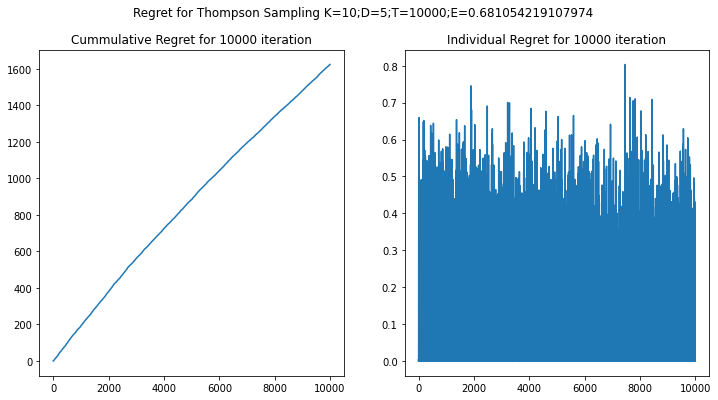

In [15]:
ts.plot_regret()

Set lower dimension than above

In [16]:
K = 10
D = 3
T = 10000
E = np.random.random(1) # 0 < e < 1 (epsilon)
norm = "l2"
global_seed = 100

ts = ThompsonSampling(K,D,T,E,norm,global_seed)

In [17]:
ts.predict()

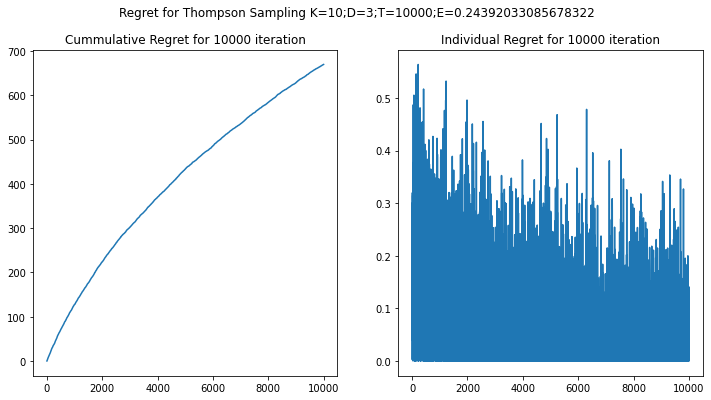

In [18]:
ts.plot_regret()